# Limits of diversification

In [125]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

pd.options.display.float_format = '{:,.5f}'.format

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

#### Functions ####
def compute_growth_rate(dataframe, initial_value=100, initial_cost=0, ending_cost=0):
    initial_cost = initial_cost / 100
    ending_cost  = ending_cost / 100
    
    GR = ((1 + dataframe.pct_change()).cumprod()) * (initial_value * (1 - initial_cost))
    GR.iloc[0]  = initial_value * (1 - initial_cost)
    GR.iloc[-1] = GR.iloc[-1] * (1 * (1 - ending_cost))
    return GR 

def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100

def compute_return(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min()

def compute_cagr(dataframe, years=0, investment_value=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
    
    if investment_value == 0:
        return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)
    else:
        return (dataframe.iloc[-1].div(investment_value).pow(1 / years)).sub(1).mul(100)

def compute_mar(dataframe):
    '''
    Function to calculate mar: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_return(dataframe, investment_value=0):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    if investment_value == 0:
        return(dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    else:
        return(dataframe.iloc[-1] / investment_value -1) * 100

def compute_performance_table(dataframe, years='si', freq='days', investment_value=0):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
        
        df = pd.DataFrame([compute_return(dataframe, investment_value), compute_cagr(dataframe, years, investment_value), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['Return', 'CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        df['Max DD'] = (df['Max DD'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df
    
    else:
        df = pd.DataFrame([compute_return(dataframe, investment_value), compute_cagr(dataframe, years, investment_value), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df

def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day < 0:
        day = - day
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years ' + str(month) + ' Months ' + str(day) + ' Days')

def filter_by_date(dataframe, years=0, previous_row=False):
    
    last_date = dataframe.tail(1).index
    year_nr = last_date.year.values[0]
    month_nr = last_date.month.values[0]
    day_nr = last_date.day.values[0]
            
    new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr)
    
    if previous_row == False:
        return dataframe.loc[new_date:]
    
    elif previous_row == True:
        return pd.concat([dataframe.loc[:new_date].tail(1), dataframe.loc[new_date:]])
    
def get(quotes):

    # resample quotes to business month
    monthly_quotes = quotes.resample('BM').last()
    
    # get monthly returns
    returns = monthly_quotes.pct_change()

    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plot(returns,
         title="Monthly Returns (%)",
         title_color="black",
         title_size=12,
         annot_size=10,
         figsize=None,
         cmap='RdYlGn',
         cbar=False,
         square=False):

    returns = get(returns)
    returns *= 100
    
    if figsize is None:
        size = list(plt.gcf().get_size_inches()) 
        figsize = (size[0], size[0] // 2)
        plt.close()

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(returns, ax=ax, annot=True,
                     annot_kws={"size": annot_size}, fmt="0.2f", linewidths=0.4, center=0,
                     square=square, cbar=cbar, cmap=cmap)
    ax.set_title(title, fontsize=title_size, color=title_color, fontweight="bold")

    fig.subplots_adjust(hspace=0)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()


PandasObject.get_returns_heatmap = get
PandasObject.plot_returns_heatmap = plot

def calendarize(returns):
    
    '''
    The calendarize function is an slight adaption of ranaroussi's monthly-returns-heatmap 
    You can find it here: https://github.com/ranaroussi/monthly-returns-heatmap/
    
    It turns monthly data into a 12 columns(months) and yearly row seaborn heatmap
    '''
    
    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plotly_table(df, width=990, height=500, columnwidth=[25], title=None , index=True, header=True,
                 header_alignment=['center'],  header_line_color='rgb(100, 100, 100)', header_font_size=[12],
                 header_font_color=['rgb(45, 45, 45)'], header_fill_color=['rgb(200, 200, 200)'],
                 cells_alignment=['center'], cells_line_color=['rgb(200, 200, 200)'], cells_font_size=[11], 
                 cells_font_color=['rgb(45, 45, 45)'], cells_fill_color=['rgb(245, 245, 245)','white' ]):
    
    # Making the header bold and conditional  
        if (header == False and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header.pop(0)
            header =  [[]] + header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
              
        # Making the header bold and conditional  
        if (header == True and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [['']] + header
            
            # Making the index Bold
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == False and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [[]] + header
            
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == True and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
        
        if title == None:
            layout = go.Layout(
                autosize=False,
                height=height,
                width=width,
                margin=go.Margin( l=0, r=0, b=0, t=0, pad=0),
            )
        else:
                layout = go.Layout(
                    autosize=False,
                    height=height,
                    width=width,
                    title=title,
                    margin=go.Margin( l=0, r=0, b=0, t=25, pad=0),
                )

        data = [trace]
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, show_link=False, config={'modeBarButtonsToRemove': ['sendDataToCloud','hoverCompareCartesian'],
                                               'displayModeBar': False})

def compute_portfolio(quotes, weights):
    
    # Anos do Portfolio
    Years = quotes.index.year.unique()

    # Dicionário com Dataframes anuais das cotações dos quotes
    Years_dict = {}
    k = 0

    for Year in Years:
        # Dynamically create key
        key = Year
        # Calculate value
        value = quotes.loc[str(Year)]
        # Insert in dictionary
        Years_dict[key] = value
        # Counter
        k += 1

    # Dicionário com Dataframes anuais das cotações dos quotes
    Quotes_dict = {}
    Portfolio_dict = {}

    k = 0    
    
    for Year in Years:
        
        n = 0
        
        #Setting Portfolio to be a Global Variable
        global Portfolio
        
        # Dynamically create key
        key = Year

        # Calculate value
        if (Year-1) in Years:
            value = Years_dict[Year].append(Years_dict[Year-1].iloc[[-1]]).sort_index()
        else:
            value = Years_dict[Year].append(Years_dict[Year].iloc[[-1]]).sort_index()

        # Set beginning value to 100
        value = (value / value.iloc[0]) * 100
        # 
        for column in value.columns:
            value[column] = value[column] * weights[n]
            n +=1
        
        # Get Returns
        Returns = value.pct_change()
        # Calculating Portfolio Value
        value['Portfolio'] = value.sum(axis=1)

        # Creating Weights_EOP empty DataFrame
        Weights_EOP = pd.DataFrame()
        # Calculating End Of Period weights
        for Name in Nomes:
            Weights_EOP[Name] = value[Name] / value['Portfolio']
        # Calculating Beginning Of Period weights
        Weights_BOP = Weights_EOP.shift(periods=1)

        # Calculatins Portfolio Value
        Portfolio = pd.DataFrame(Weights_BOP.multiply(Returns).sum(axis=1))
        Portfolio.columns=['Simple']
        # Transformar os simple returns em log returns 
        Portfolio['Log'] = np.log(Portfolio['Simple'] + 1)
        # Cumsum() dos log returns para obter o preço do Portfolio 
        Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        Portfolio['Price'] = Portfolio['Price']   

        # Insert in dictionaries
        Quotes_dict[key] = value
        Portfolio_dict[key] = Portfolio
        # Counter
        k += 1

    # Making an empty Dataframe for Portfolio data
    Portfolio = pd.DataFrame()

    for Year in Years:
        Portfolio = pd.concat([Portfolio, Portfolio_dict[Year]['Log']])

    # Delete repeated index values in Portfolio    
    Portfolio.drop_duplicates(keep='last')

    # Naming the column of log returns 'Log'
    Portfolio.columns= ['Log']

    # Cumsum() dos log returns para obter o preço do Portfolio 
    Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        
    # Round Portfolio to 2 decimals and eliminate returns
    Portfolio = pd.DataFrame(round(Portfolio['Price'], 2))

    # Naming the column of Portfolio as 'Portfolio'
    Portfolio.columns= ['Portfolio']

    # Delete repeated days
    Portfolio = Portfolio.loc[~Portfolio.index.duplicated(keep='first')]

    return Portfolio
    
# Multi_period_return (in CAGR)
def multi_period_return(df, years = 1, days=252):
    shifted = df.shift(days * years)
    One_year = (((1 + (df - shifted) / shifted) ** (1 / years))-1)  * 100
    return One_year

def compute_drawdowns_i(dataframe):
    '''
    Function to compute drawdowns based on 
    the inicial value of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / 100 -1) * 100
        
def print_title(string):
    display(Markdown('**' + string + '**'))
    
def all_percent(df):
    for column in df.columns:
        df[column] = df[column].apply( lambda x : str(x) + '%')
        return df

def preview(df):
    return pd.concat([df.head(3), df.tail(3)])

dimensions=(990, 500)

colorz = ['royalblue', 'orange', 'dimgrey', 'darkorchid']

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### print color.BOLD + 'Hello World !' + color.END

##################################################
### Begin of compute_drawdowns_table function ####
##################################################

### Função auxiliar 1
def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day == 0:
        day = - day
        
    if day < 0:
        month =  month - 1
        if timestamp_1.month not in [1, 3, 5, 7, 8, 10, 12]:
            day = 31 + day
        else:
            day = 30 + day        
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years, ' + str(month) + ' Months, ' + str(day) + ' Days')

### Função auxiliar 2
def compute_drawdowns_periods(df):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdown_periods = list()

    for i in range(0, len(df.index)):
      
        drawdown_periods.append(compute_time_period(df.index[i], df.index[i - 1]))
    
    drawdown_periods = pd.DataFrame(drawdown_periods)
    
    return (drawdown_periods)


### Função auxiliar 3
def compute_max_drawdown_in_period(prices, timestamp_1, timestamp_2):
    
    df = prices[timestamp_1:timestamp_2]
    
    max_dd = compute_max_DD(df)
    
    return max_dd

### Função auxiliar 4
def compute_drawdowns_min(df, prices):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdowns_min = list()

    for i in range(0, len(df.index) - 1):
      
        drawdowns_min.append(compute_max_drawdown_in_period(prices, df.index[i], df.index[i + 1]))
    
    drawdowns_min = pd.DataFrame(drawdowns_min)
    
    return(drawdowns_min)

### Função principal
def compute_drawdowns_table(prices, number=5):

    # input: df of prices
    dd = compute_drawdowns(prices)
    
    max_points = dd[dd == 0].dropna()
        
    data = [0.0] 
  
    # Create the pandas DataFrame
    new_data = pd.DataFrame(data, columns = ['New_data'])

    new_data['Date'] = prices.index.max()

    new_data.set_index('Date', inplace=True)

    max_points = pd.DataFrame(pd.concat([max_points, new_data], axis=1).iloc[:, 0])
    
    dp = compute_drawdowns_periods(max_points)
        
    dp.set_index(max_points.index, inplace=True)
    
    df = pd.concat([max_points, dp], axis=1)
    
    df.index.name = 'Date'
    
    df.reset_index(inplace=True)
    
    df['End'] = df['Date'].shift(-1)
    
    df[0] = df[0].shift(-1)
    
    df['values'] = round(compute_drawdowns_min(max_points, prices), 2)
    
    df = df.sort_values(by='values')
    
    df['Number'] = range(1, len(df) + 1)
    
    df.reset_index(inplace=True)
    
    df.columns = [['index', 'Begin', 'point', 'Length', 'End', 'Depth', 'Number']]
    
    df = df[['Begin', 'End', 'Depth', 'Length']].head(number)
    
    df.iloc[:, 2] = df.iloc[:, 2].apply( lambda x : str(x) + '%')
    
    df.set_index(np.arange(1, number + 1), inplace=True)
               
    for index, row in df['End'].iterrows():
        
        if ( (row[0] == prices.index.max())):# & (prices.iloc[-1][0] < prices.max()) ):
            
            df.iloc[index-1, 1] = float('NaN')

    return(df)

################################################
### End of compute_drawdowns_table function ####
################################################

def compute_r2(x, y, k=1):
    xpoly = np.column_stack([x**i for i in range(k+1)])    
    return sm.OLS(y, xpoly).fit().rsquared

def compute_r2_table(df, benchmark):

# df of prices

    lista = []

    for i in np.arange(0, len(df.columns)):
        lista.append(compute_r2(benchmark, df.iloc[: , i]))
             
    Dataframe = pd.DataFrame(lista)
    
    Dataframe.index = df.columns
    
    Dataframe.columns = [benchmark.name]
    
    return(round(Dataframe.transpose(), 3))

colors = ['royalblue',            # 1 - royalblue
          'dimgrey',              # 2 - dimgrey
          'rgb(255, 153, 51)',    # 3 - orange
          'indigo',               # 4 - Indigo
          'rgb(219, 64, 82)',     # 5 - Red
          'rgb(0, 128, 128)',     # 6 - Teal
          '#191970',              # 7 - Navy
          'rgb(128, 128, 0)',     # 8 - Olive
          '#00BFFF',              # 9 - Water Blue
          'rgb(128, 177, 211)']   # 10 - Blueish

In [126]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk
import matplotlib.pyplot as plt

# Set matplotlib style
plt.style.use('seaborn')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
### Functions ####
def compute_growth_rate(dataframe, initial_value=100, initial_cost=0, ending_cost=0):
    initial_cost = initial_cost / 100
    ending_cost  = ending_cost / 100
    
    GR = ((1 + dataframe.pct_change()).cumprod()) * (initial_value * (1 - initial_cost))
    GR.iloc[0]  = initial_value * (1 - initial_cost)
    GR.iloc[-1] = GR.iloc[-1] * (1 * (1 - ending_cost))
    return GR 

def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100

def compute_return(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min()

def compute_cagr(dataframe, years=0, investment_value=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
    
    if investment_value == 0:
        return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)
    else:
        return (dataframe.iloc[-1].div(investment_value).pow(1 / years)).sub(1).mul(100)

def compute_mar(dataframe):
    '''
    Function to calculate mar: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_return(dataframe, investment_value=0):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    if investment_value == 0:
        return(dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    else:
        return(dataframe.iloc[-1] / investment_value -1) * 100

def compute_performance_table(dataframe, years='si', freq='days', investment_value=0):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
        
        df = pd.DataFrame([compute_return(dataframe, investment_value), compute_cagr(dataframe, years, investment_value), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['Return', 'CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        df['Max DD'] = (df['Max DD'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df
    
    else:
        df = pd.DataFrame([compute_return(dataframe, investment_value), compute_cagr(dataframe, years, investment_value), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df

In [128]:
ind_return = erk.get_ind_returns()
ind_nfirms = erk.get_ind_nfirms()
ind_size = erk.get_ind_size()

In [129]:
ind_return.shape

(1110, 30)

In [130]:
ind_nfirms.shape

(1110, 30)

In [131]:
ind_size.shape

(1110, 30)

In [132]:
ind_nfirms.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,43.00000,3.00000,16.00000,7.00000,2.00000,8.00000,12.00000,7.00000,17.00000,13.00000,...,5.00000,3.00000,7.00000,6.00000,74.00000,2.00000,33.00000,6.00000,12.00000,4.00000
1926-08,43.00000,3.00000,16.00000,7.00000,2.00000,8.00000,12.00000,7.00000,17.00000,13.00000,...,5.00000,3.00000,7.00000,6.00000,74.00000,2.00000,33.00000,6.00000,12.00000,4.00000
1926-09,43.00000,3.00000,16.00000,7.00000,2.00000,8.00000,12.00000,7.00000,17.00000,13.00000,...,5.00000,3.00000,7.00000,6.00000,74.00000,2.00000,33.00000,6.00000,12.00000,4.00000
1926-10,43.00000,3.00000,16.00000,7.00000,2.00000,8.00000,12.00000,7.00000,17.00000,13.00000,...,5.00000,3.00000,7.00000,6.00000,74.00000,2.00000,33.00000,6.00000,12.00000,4.00000
1926-11,43.00000,3.00000,16.00000,7.00000,2.00000,8.00000,12.00000,7.00000,17.00000,13.00000,...,5.00000,3.00000,7.00000,6.00000,74.00000,2.00000,33.00000,6.00000,12.00000,4.00000


In [133]:
ind_mktcap = ind_nfirms * ind_size
ind_mktcap.shape

(1110, 30)

In [134]:
total_mktcap = ind_mktcap.sum(axis='columns')

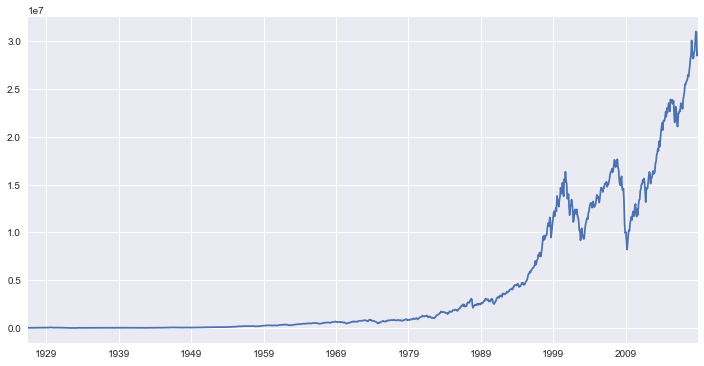

In [135]:
total_mktcap.plot(figsize=(12, 6));

In [136]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis='rows')

In [137]:
ind_capweight.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.05804,0.00080,0.03584,0.00693,0.00090,0.00668,0.00826,0.00670,0.03673,0.00301,...,0.06571,0.00153,0.01489,0.00796,0.18574,0.00009,0.05775,0.00244,0.00848,0.00364
1926-08,0.05658,0.00074,0.03526,0.00693,0.00097,0.00645,0.00867,0.00658,0.03850,0.00294,...,0.06438,0.00161,0.01473,0.00828,0.18338,0.00007,0.05601,0.00241,0.00826,0.00372
1926-09,0.05670,0.00092,0.03651,0.00681,0.00105,0.00604,0.00825,0.00667,0.03970,0.00311,...,0.06432,0.00161,0.01487,0.00787,0.18729,0.00007,0.05423,0.00234,0.00841,0.00388
1926-10,0.05692,0.00095,0.03674,0.00718,0.00103,0.00605,0.00814,0.00670,0.04149,0.00316,...,0.06490,0.00164,0.01485,0.00744,0.18681,0.00006,0.05428,0.00231,0.00828,0.00373
1926-11,0.05673,0.00095,0.03828,0.00705,0.00116,0.00592,0.00840,0.00683,0.04066,0.00327,...,0.06687,0.00164,0.01512,0.00724,0.18705,0.00005,0.05464,0.00228,0.00810,0.00352


In [138]:
ind_capweight.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2018-08,0.02187,0.00831,0.00822,0.01200,0.00117,0.01457,0.00972,0.10355,0.01760,0.00062,...,0.03990,0.16104,0.10840,0.01009,0.02345,0.01099,0.07623,0.01432,0.16464,0.04781
2018-09,0.02101,0.00787,0.00751,0.01192,0.00108,0.01443,0.00987,0.10432,0.01695,0.00062,...,0.03967,0.16360,0.11495,0.00968,0.02325,0.01099,0.08023,0.01427,0.16256,0.04755
2018-10,0.02066,0.00786,0.00783,0.01185,0.00105,0.01461,0.01000,0.10636,0.01495,0.00058,...,0.04043,0.16311,0.11471,0.00965,0.02353,0.01068,0.08089,0.01466,0.15946,0.04816
2018-11,0.02265,0.00840,0.00918,0.01081,0.00107,0.01570,0.00976,0.10508,0.01418,0.00047,...,0.04348,0.16019,0.11446,0.00933,0.02306,0.01067,0.07885,0.01564,0.16102,0.04916
2018-12,0.02283,0.00876,0.00829,0.01059,0.00108,0.01648,0.00951,0.10993,0.01463,0.00047,...,0.04395,0.15980,0.10619,0.00992,0.02391,0.01085,0.07710,0.01625,0.16305,0.05007


In [139]:
ind_capweight['1926'].sum(axis='columns')

1926-07   1.00000
1926-08   1.00000
1926-09   1.00000
1926-10   1.00000
1926-11   1.00000
1926-12   1.00000
Freq: M, dtype: float64

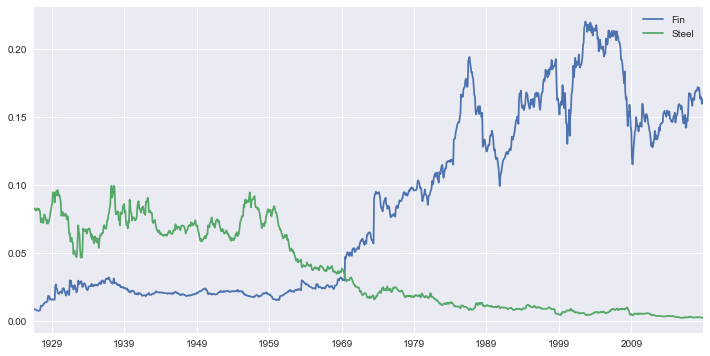

In [140]:
ind_capweight[['Fin', 'Steel']].plot(figsize=(12, 6));

In [141]:
total_market_return = (ind_capweight * ind_return).sum(axis='columns')

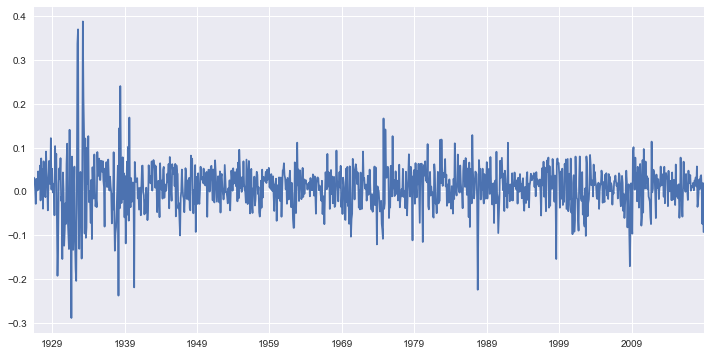

In [142]:
total_market_return.plot(figsize=(12, 6));

In [143]:
total_market_index = erk.drawdown(total_market_return).Wealth

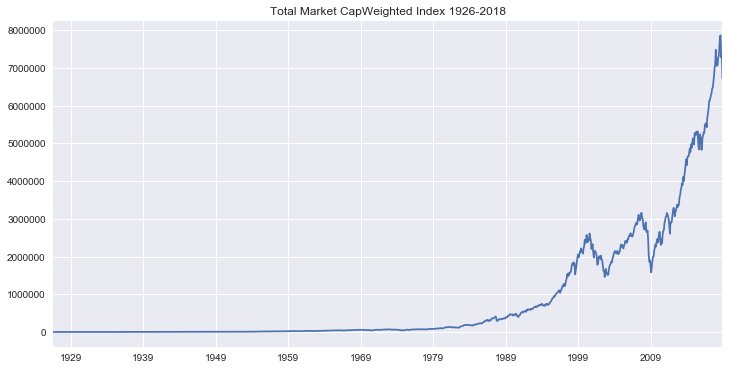

In [144]:
total_market_index.plot(figsize=(12, 6), title='Total Market CapWeighted Index 1926-2018');

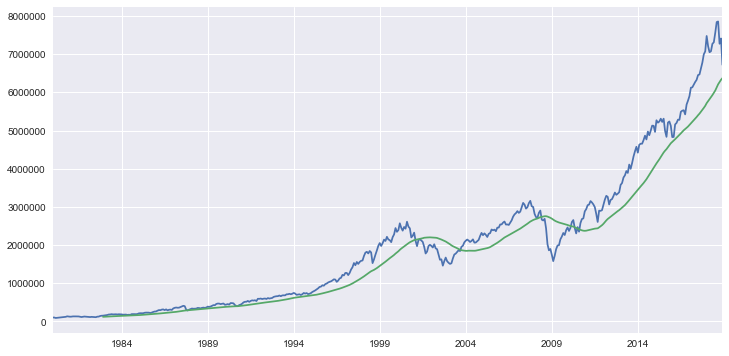

In [145]:
total_market_index['1980':].plot(figsize=(12, 6));
total_market_index['1980':].rolling(window=36).mean().plot(figsize=(12, 6));

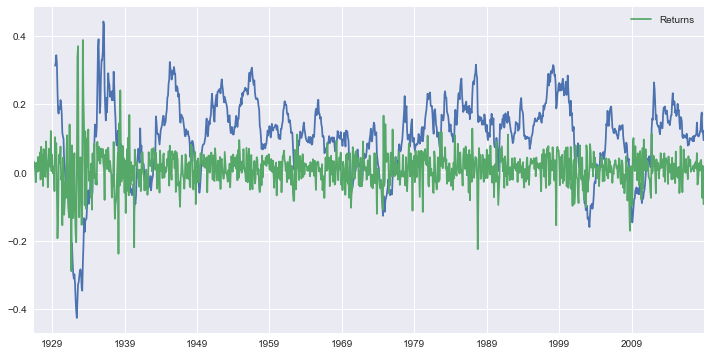

In [146]:
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(erk.annualize_rets, periods_per_year=12)
tmi_tr36rets.plot(figsize=(12, 6), label='Trailing 36 month Returns')
total_market_return.plot(label='Returns', legend=True);

# Rolling correlations - along with MultiIndexes and .groupby

In [147]:
ts_corr = ind_return.rolling(window=36).corr()

In [148]:
ts_corr.tail()

Food    Beer   Smoke   Games   Books   Hshld   Clths    Hlth   Chems   Txtls  ...   Telcm   Servs   BusEq   Paper   Trans   Whlsl   Rtail   Meals     Fin   Other
2018-12 Whlsl 0.47495 0.35698 0.12267 0.51043 0.80336 0.41928 0.57007 0.73976 0.78580 0.63420  ... 0.64809 0.56739 0.54336 0.76425 0.82919 1.00000 0.74484 0.64388 0.74648 0.76765
        Rtail 0.51786 0.40611 0.03028 0.67646 0.63632 0.35834 0.67660 0.71493 0.62603 0.63420  ... 0.56224 0.76262 0.62825 0.65651 0.63061 0.74484 1.00000 0.61695 0.61188 0.61992
        Meals 0.37019 0.38548 0.12201 0.30152 0.52065 0.30822 0.30218 0.41619 0.52002 0.49173  ... 0.40618 0.44463 0.39944 0.62711 0.66336 0.64388 0.61695 1.00000 0.50256 0.60523
        Fin   0.29882 0.19271 0.02759 0.48028 0.69481 0.16269 0.42590 0.65847 0.76015 0.57709  ... 0.42086 0.58542 0.51795 0.67094 0.76073 0.74648 0.61188 0.50256 1.00000 0.73484
        Other 0.43695 0.37657 0.22401 0.33183 0.55807 0.39061 0.46710 0.64503 0.71251 0.52095  ... 0.60787 0.46032 0.43449 0.77380 0.75696 0.76765 0.61992 0.60523 0.73484 1.00000

[5 rows x 30 columns]

In [149]:
ts_corr.index.names = ['Date', 'Industry']
ts_corr.tail()

Food    Beer   Smoke   Games   Books   Hshld   Clths    Hlth   Chems   Txtls  ...   Telcm   Servs   BusEq   Paper   Trans   Whlsl   Rtail   Meals     Fin   Other
Date    Industry                                                                                  ...                                                                                
2018-12 Whlsl    0.47495 0.35698 0.12267 0.51043 0.80336 0.41928 0.57007 0.73976 0.78580 0.63420  ... 0.64809 0.56739 0.54336 0.76425 0.82919 1.00000 0.74484 0.64388 0.74648 0.76765
        Rtail    0.51786 0.40611 0.03028 0.67646 0.63632 0.35834 0.67660 0.71493 0.62603 0.63420  ... 0.56224 0.76262 0.62825 0.65651 0.63061 0.74484 1.00000 0.61695 0.61188 0.61992
        Meals    0.37019 0.38548 0.12201 0.30152 0.52065 0.30822 0.30218 0.41619 0.52002 0.49173  ... 0.40618 0.44463 0.39944 0.62711 0.66336 0.64388 0.61695 1.00000 0.50256 0.60523
        Fin      0.29882 0.19271 0.02759 0.48028 0.69481 0.16269 0.42590 0.65847 0.76015 0.57709  ... 0.42086 0.58542 0.51795 0.67094 0.76073 0.74648 0.61188 0.50256 1.00000 0.73484
        Other    0.43695 0.37657 0.22401 0.33183 0.55807 0.39061 0.46710 0.64503 0.71251 0.52095  ... 0.60787 0.46032 0.43449 0.77380 0.75696 0.76765 0.61992 0.60523 0.73484 1.00000

[5 rows x 30 columns]

In [150]:
ind_tr36corr= ts_corr.groupby(level='Date').apply(lambda cormat: cormat.values.mean())

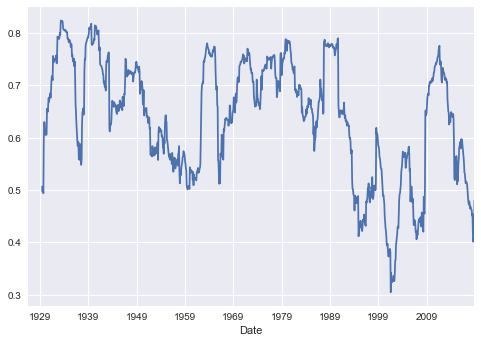

In [151]:
ind_tr36corr.plot();

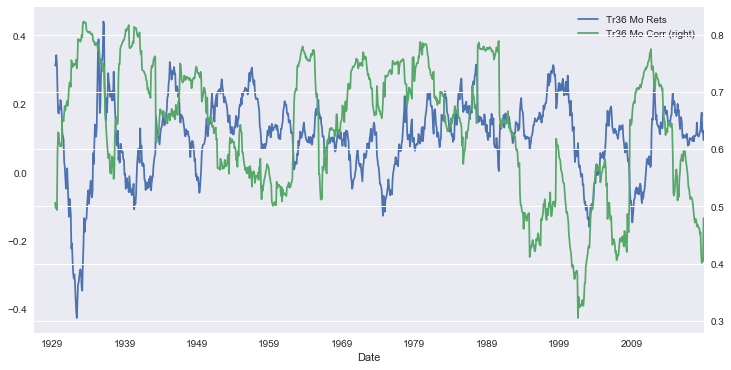

In [152]:
tmi_tr36rets.plot(label='Tr36 Mo Rets', figsize=(12, 6), legend=True)
ind_tr36corr.plot(label='Tr36 Mo Corr', figsize=(12, 6), legend=True, secondary_y=True);

In [153]:
tmi_tr36rets.corr(ind_tr36corr)

-0.2801006506288412

### Lab session-CPPI and Drawdown Constraints-Part1

In [154]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set matplotlib style
plt.style.use('seaborn')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
# Load datasets
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [156]:
risky_r = ind_return['2000':][['Steel', 'Fin', 'Beer']]

In [157]:
# Safe Asset
safe_r = pd.DataFrame().reindex_like(risky_r)

In [158]:
safe_r[:] = 0.03 / 12
start = 1000
floor = 0.8

1. Cushion = (Asset Value minus Floor Value)
2. Compute an Allocation to Safe and Riscky Assets ----> m * risk budget
3. Recompute the asset Asset Value Based on the Returns

In [159]:
date = risky_r.index
n_steps = len(date)
account_value = start
floor_value = start * floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value) / account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w  = 1 - risky_w
    
    risky_alloc = account_value * risky_w
    safe_alloc  = account_value * safe_w
    
    # update the account value for this time step
    account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])
    
    # save the values so i can look at the history and plot it etc
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value

In [160]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.38000,974.48000,987.32000
2000-02,"1,023.29288",931.16754,922.97126
2000-03,"1,047.55518",998.18730,924.83599
2000-04,"1,042.07901",973.92748,939.99370
2000-05,"1,007.13775","1,001.46003",991.14549


In [161]:
risky_weath = start * (1 + risky_r).cumprod()

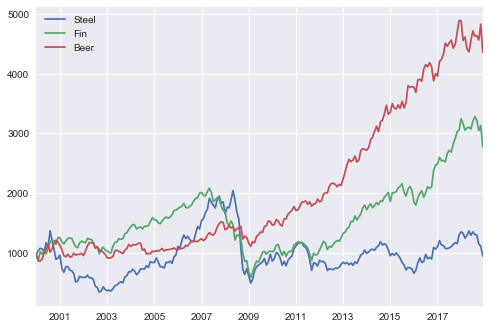

In [162]:
risky_weath.plot();

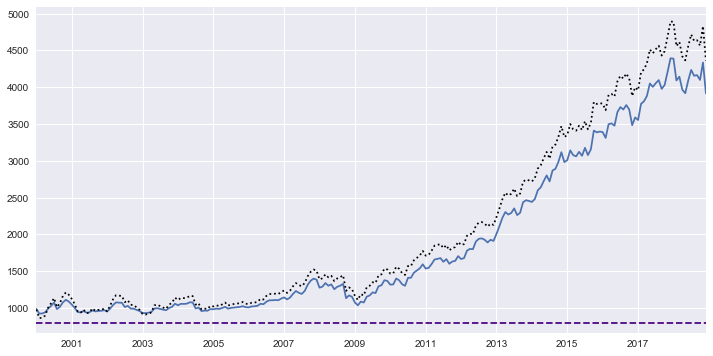

In [163]:
ax = account_history['Beer'].plot(figsize=(12, 6))
risky_weath['Beer'].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='indigo', linestyle='--');

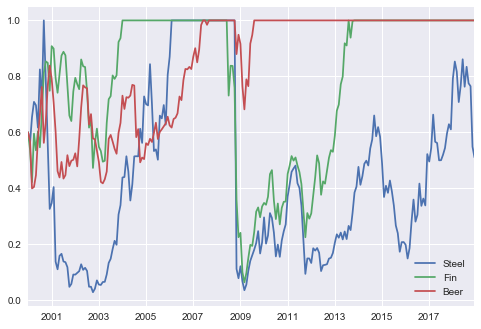

In [164]:
risky_w_history.plot();

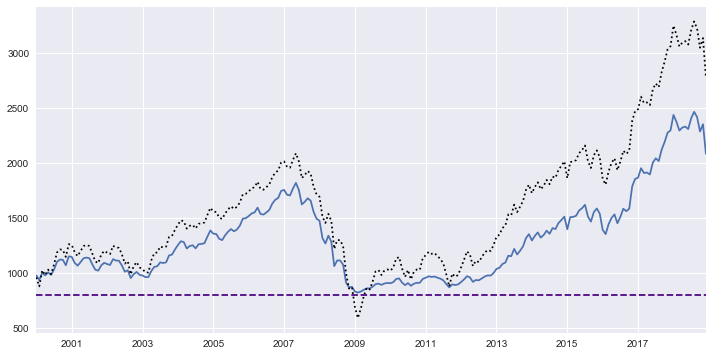

In [165]:
ind = 'Fin'
ax = account_history[ind].plot(figsize=(12, 6))
risky_weath[ind].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='indigo', linestyle='--');

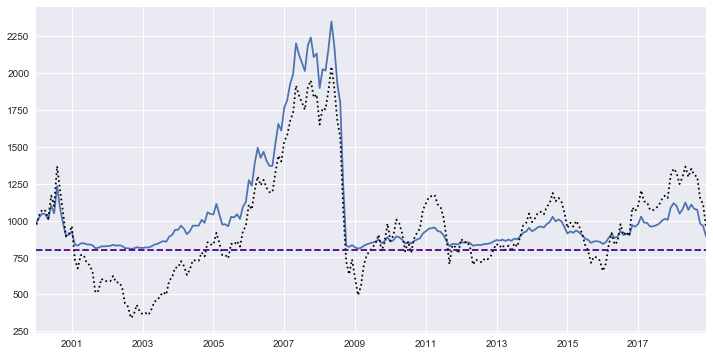

In [166]:
ind = 'Steel'
ax = account_history[ind].plot(figsize=(12, 6))
risky_weath[ind].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='indigo', linestyle='--');

In [167]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.00279,0.31237,-0.32633,4.14438,0.15014,0.20812,-0.10257,-0.75802
Fin,0.05517,0.19291,-0.53322,4.99553,0.09122,0.13218,0.12672,-0.71846
Beer,0.08060,0.13892,-0.49355,4.17388,0.06302,0.09144,0.35431,-0.27137


In [168]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.00517,0.17418,-1.99514,17.11019,0.09200,0.13015,-0.19675,-0.65520
Fin,0.04089,0.13168,-0.94650,6.05141,0.06554,0.09162,0.08035,-0.54967
Beer,0.07554,0.11546,-0.66925,4.76088,0.05292,0.07491,0.38377,-0.25958


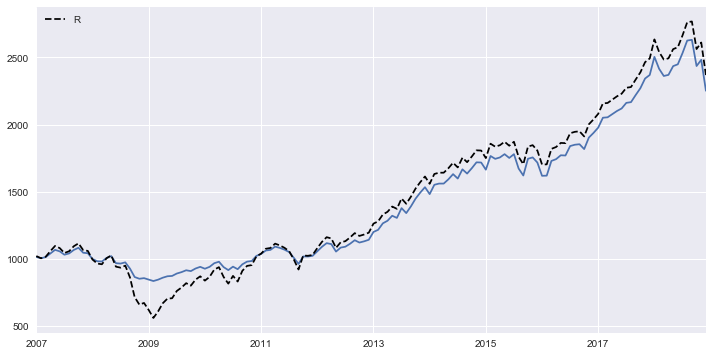

In [169]:
btr = erk.run_cppi(tmi_return['2007':])
ax = btr['Wealth'].plot(figsize=(12, 6), legend=False)
btr['Risky Wealth'].plot(ax=ax, style='k--');

In [170]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.07341,0.15046,-0.73494,4.52349,0.07159,0.09632,0.28062,-0.49994


In [171]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.06942,0.10038,-0.58829,3.74093,0.04568,0.06295,0.38205,-0.22968


# Drawdown Constrain

In [172]:
btr = erk.run_cppi(ind_return['2007':][['Steel', 'Fin', 'Beer']], drawdown = 0.25)

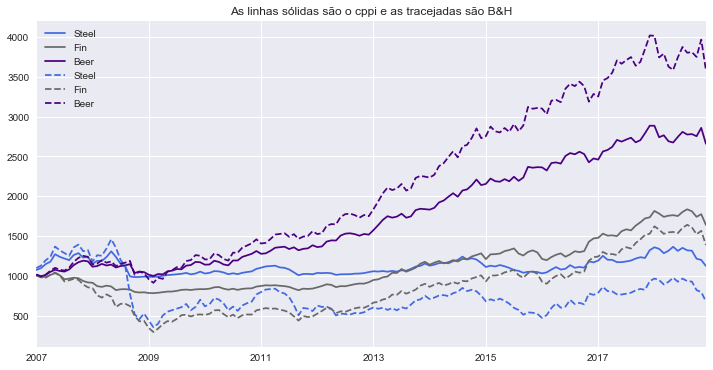

In [173]:
ax =btr['Wealth'].plot(figsize=(12, 6), color=['royalblue', 'dimgrey', 'indigo'])
btr['Risky Wealth'].plot(ax=ax, color=['royalblue', 'dimgrey', 'indigo'], style='--', title='As linhas sólidas são o cppi e as tracejadas são B&H');

In [174]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.03966,0.30641,-0.45995,4.78283,0.15229,0.20384,-0.22164,-0.75802
Fin,0.02736,0.21220,-0.69520,4.62140,0.10574,0.14986,-0.01237,-0.71846
Beer,0.11155,0.12797,-0.67080,4.65088,0.05650,0.07739,0.62013,-0.27137


In [175]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.00378,0.09707,-0.44109,5.22048,0.04737,0.06699,-0.26296,-0.24806
Fin,0.04197,0.08503,-0.35516,4.15386,0.03834,0.05411,0.13696,-0.24363
Beer,0.08438,0.08626,-0.74411,4.57153,0.03794,0.05119,0.61341,-0.16119


# Random Walk Generation

$$ \frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

In [176]:
import pandas as pd
import numpy as np

def gbm(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    '''
    Evolution of a stock price using a Geometric Brownian Motion Model
    '''
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year)
    xi = np.random.normal(size=(n_steps, n_scenarios))
    rets = (mu * dt) + (sigma * np.sqrt(dt) * xi)
    rets = pd.DataFrame(rets)
    # to prices
    prices = s_0 * (1+rets).cumprod()
    return prices

In [177]:
p = gbm(10, n_scenarios=3)

In [178]:
p.shape

(120, 3)

In [179]:
p.head()

,0,1,2
0,91.87114,105.31261,93.31047
1,91.78160,105.48617,92.98602
2,93.43652,108.69566,100.51381
3,95.32038,109.68111,109.38766
4,96.83979,105.45797,111.57598


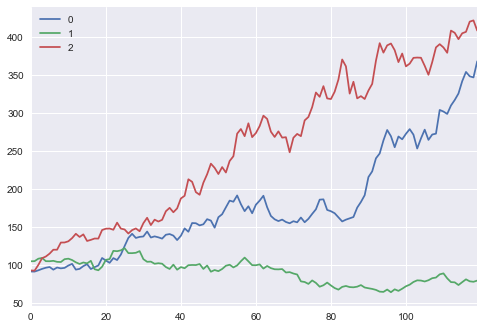

In [180]:
p.plot();

Wall time: 11.6 s


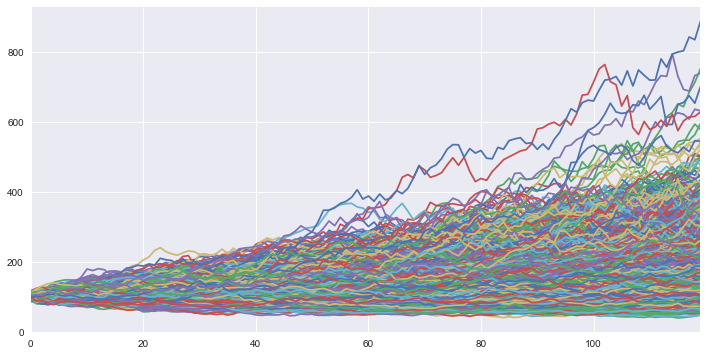

In [181]:
%%time
p = gbm(n_years=10, n_scenarios=1000).plot(figsize=(12, 6), legend=False)

In [182]:
%%time
p = gbm(n_years=10, n_scenarios=1000)

Wall time: 552 ms


In [183]:
def gbm0(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    '''
    Evolution of a stock price using a Geometric Brownian Motion Model
    '''
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year)
    xi = np.random.normal(size=(n_steps, n_scenarios))
    rets = (mu * dt) + (sigma * np.sqrt(dt) * xi)
    rets = pd.DataFrame(rets)
    # to prices
    prices = s_0 * (1+rets).cumprod()
    return prices

In [184]:
def gbm1(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    '''
    Evolution of a stock price using a Geometric Brownian Motion Model
    '''
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year)
    rets_plus_1 = np.random.normal(loc=(1+mu*dt), scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios)) # Loc is the mean and scale is the stadard deviation/ nomral distribution
    # to prices
    prices = s_0 * (rets_plus_1).cumprod()
    return prices

In [185]:
def gbm(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    '''
    Evolution of a stock price using a Geometric Brownian Motion Model
    '''
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year)
    rets_plus_1 = np.random.normal(loc=(1+mu*dt), scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios)) # Loc is the mean and scale is the stadard deviation/ normal distribution
    # to prices
    prices = s_0 * pd.DataFrame(rets_plus_1).cumprod()
    return prices

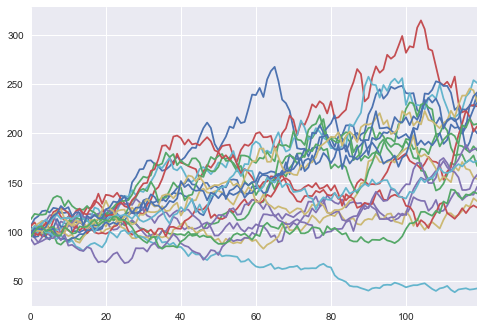

In [186]:
gbm(n_years=10, n_scenarios=20).plot(legend=False);

In [187]:
def gbm1(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    '''
    Evolution of a stock price using a Geometric Brownian Motion Model
    '''
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year)
    rets_plus_1 = np.random.normal(loc=(1+mu*dt), scale=(sigma*np.sqrt(dt)), size=(n_steps + 1, n_scenarios)) # Loc is the mean and scale is the stadard deviation/ nomral distribution
    rets_plus_1[0] = 1
    # to prices
    prices = s_0 * (rets_plus_1).cumprod()
    return prices

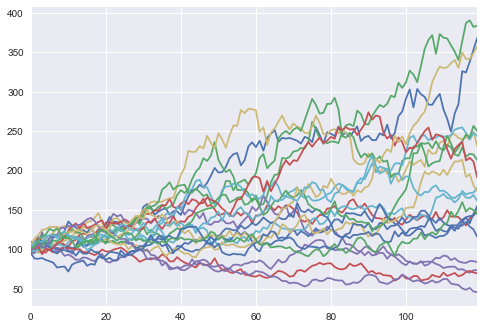

In [188]:
gbm(n_years=10, n_scenarios=20).plot(legend=False);

# IpyWidgets

In [189]:
import ipywidgets as widgets

In [190]:
def squareit(n):
    return n*n

In [191]:
squareit(5)

25

In [192]:
widgets.interact(squareit, n=(0, 100))

interactive(children=(IntSlider(value=50, description='n'), Output()), _dom_classes=('widget-interact',))

<function __main__.squareit(n)>

# Lab session - interactive plots of monte Carlo Simulations of CPPI and GBM-Part1

In [193]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Set matplotlib style
plt.style.use('seaborn')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### GMB Interactive Plots

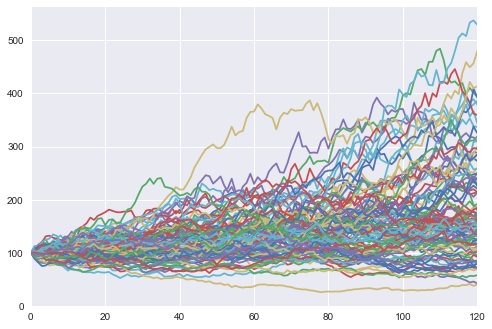

In [194]:
erk.gbm(10, 100).plot(legend=False);

In [195]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    s_0=100
    prices = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax = prices.plot(legend=False, alpha = 0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=s_0, ls=":", color="black")
    # draw a dot at the origin
    ax.plot(0,s_0, marker='o', alpha=0.2)

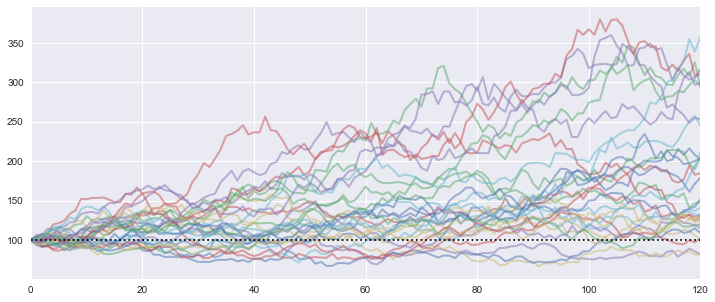

In [196]:
show_gbm(30, 0.07, 0.15)

In [197]:
gbm_controls = widgets.interactive(show_gbm,
                                   n_scenarios = (1, 20, 1),
                                   mu = (-0.2, 0.2, 0.01),
                                   sigma = (0, 0.3, 0.01)
                                  )

In [198]:
display(gbm_controls)

interactive(children=(IntSlider(value=10, description='n_scenarios', max=20, min=1), FloatSlider(value=0.0, de…

## Interactive CPPI Simulation - Monte Carlo

In [199]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    y_max = wealth.values.max()*y_max/100
    ax = wealth.plot(legend=False, alpha=0.3, figsize=(12, 6))
    ax.axhline(y=start, ls=":", color="black", alpha=0.5)
    ax.axhline(y=start*floor, ls="--", color="indigo", alpha=0.5)
    ax.set_ylim(top=y_max)

cppi_controls = widgets.interactive(show_cppi, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=10, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .30, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=10), FloatSlider(va…

In [200]:
import matplotlib as plt

In [201]:
import matplotlib.pyplot as plt

def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.006)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.4)
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="indigo")
    wealth_ax.set_ylim(top=y_max)
            
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', color='royalblue', orientation='horizontal', alpha=0.7)
    hist_ax.axhline(y=start, ls=":", color="black")

cppi_controls = widgets.interactive(show_cppi, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .3, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

In [202]:
import matplotlib.pyplot as plt
import numpy as np

def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, steps_per_year=12, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=steps_per_year)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]

    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    tw_std = terminal_wealth.std()
    failure_mask = np.less(terminal_wealth, start*floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(tv-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.006)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.4)
    wealth_ax.axhline(y=start, ls=":", color="black", alpha=0.8)
    wealth_ax.axhline(y=start*floor, ls="--", color="indigo", alpha=0.8)
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', color='royalblue', orientation='horizontal', alpha=0.7)
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="red")
    hist_ax.axhline(y=tw_median, ls=":", color="orange")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .94),xycoords='axes fraction', fontsize=16)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .89),xycoords='axes fraction', fontsize=16)
    hist_ax.annotate(f"StdDev: ${int(tw_std)}", xy=(.7, .84),xycoords='axes fraction', fontsize=16)
    
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="magenta", linewidth=1, alpha=0.7)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=16)

cppi_controls = widgets.interactive(show_cppi,
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .3, .02),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   steps_per_year=widgets.IntSlider(min=1, max=12, step=1, value=12,
                                                          description="Rebals/Year"),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…